In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import xarray
import matplotlib.pyplot as plt

In [2]:
def loadResults(path_result,path_date,fcstime,pre_h,yyyy):
    fns = os.listdir(path_result)
    fns = [fn for fn in fns if fn[:4] == yyyy]
    fns = [fn for fn in fns if fn.split('_')[-1].split('.')[0] == pre_h]
    fns = [fn for fn in fns if fn.split('_')[1] == fcstime]
    out_data = []
    for fn in fns:
        out_data.append(np.load(os.path.join(path_result,fn)))
    out_data = np.concatenate(out_data)
    
    fns = os.listdir(path_date)
    fns = [fn for fn in fns if fn[:4] == yyyy]
    fns = [fn for fn in fns if fn.split('_')[2] == pre_h]
    out_date = []
    for fn in fns:
        out_date.append(np.load(os.path.join(path_date,fn)))
    out_date = np.concatenate(out_date)
#     out_date = [dt.datetime.strftime(dt.datetime.strptime(date,'%Y%m%d%H') + dt.timedelta(hours=int(pre_h)+8),'%Y%m%d%H') for date in out_date]
    return out_data, out_date

In [3]:
sta_inf = pd.read_csv('/mnt1/zzzzzth/dataQC/data/全国站点信息20190429_国家站和自动站合集.csv')
sta_inf = sta_inf.set_index('Station_Id_C')
df_sta_cq = pd.read_excel('/mnt1/zzzzzth/chongqing/NN_T/154Tmin.xlsx')
sta = df_sta_cq['站号'].drop_duplicates()

In [4]:
# 获取经纬度
path_data = '/mnt2/ChongQin/DATA/CQMEPS5_UPP_OUT/UPP_OUT/201904/2019040400/m10/WRFPRS_d02.12'
data = xarray.open_dataset(path_data,engine='pynio')
lons, lats = data['g3_lon_1'].values[100:300,180:380], data['g3_lat_0'].values[100:300,180:380]

In [5]:
# 每个站点行列号
sta_CQ = {}
for s in sta:
    x = abs(sta_inf.loc[str(s),'Lon'] - lons)
    y = abs(sta_inf.loc[str(s),'Lat'] - lats)
    z = x**2 + y**2
    r, c = np.where(z == z.min())
    r = r[0]
    c = c[0]
    sta_CQ[str(s)] = r, c

In [6]:
fcstime = '12'
data_byday = []
date_range = pd.date_range('2020-05-01','2020-07-30')
for pre_h in range(12,36):
#     print(pre_h)
    # 加载结果
    results ,datatime = loadResults('../NN_T/results_2020/',
                                    '../samples_tem_rain/{}/'.format(fcstime),
                                    fcstime,
                                    '{:02d}'.format(pre_h),'2020')

    # 分站点结果保存
    results_station = np.zeros((results.shape[0],3,sta.shape[0]))
    for i, sta_id in enumerate(sta_CQ.keys()):
        for d in range(results.shape[0]):
                for c in range(results.shape[1]):
                    row, col = sta_CQ[sta_id]
                    results_station[d, c, i] = results[d,c,row,col]
    index = pd.Index(pd.to_datetime(datatime,format= '%Y%m%d%H'))
    df_label = pd.DataFrame(results_station[:,0,:],index = index)
    df_label = df_label.sort_index().asfreq('1d').interpolate()
    df_model = pd.DataFrame(results_station[:,1,:],index = index)
    df_model = df_model.sort_index().asfreq('1d').interpolate()
    df_nn = pd.DataFrame(results_station[:,2,:],index = index)
    df_nn = df_nn.sort_index().asfreq('1d').interpolate()
    data_byday.append([np.concatenate([[df_label.values[:90,:]],
                                       [df_model.values[:90,:]],
                                       [df_nn.values[:90,:]]])])# 有一个时次的最后一天缺失

In [7]:
data_interpolate = np.concatenate(data_byday).transpose((2,3,1,0))

In [8]:
data_interpolate.shape

(90, 154, 3, 24)

In [20]:
# 最高温
Tmax_label = data_interpolate[:,:,0,:].max(axis=2)
Tmax_model = data_interpolate[:,:,1,:].max(axis=2)
Tmax_nn = data_interpolate[:,:,2,:].max(axis=2)
MAE_Tmax_model = abs(Tmax_label - Tmax_model).mean()
MAE_Tmax_nn = abs(Tmax_label - Tmax_nn).mean()

In [21]:
# 最低温
Tmin_label = data_interpolate[:,:,0,:].min(axis=2)
Tmin_model = data_interpolate[:,:,1,:].min(axis=2)
Tmin_nn = data_interpolate[:,:,2,:].min(axis=2)
MAE_Tmin_model = abs(Tmin_label - Tmin_model).mean()
MAE_Tmin_nn = abs(Tmin_label - Tmin_nn).mean()

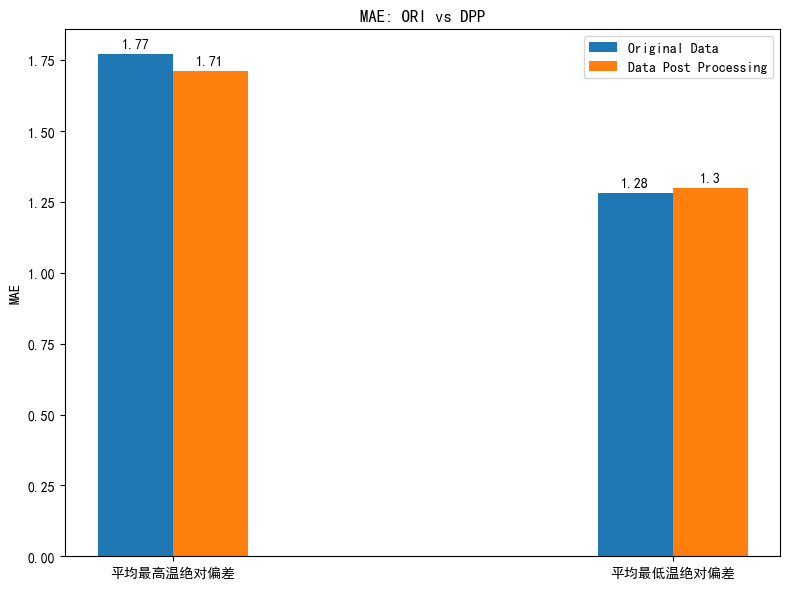

In [22]:
# 高低温平均绝对偏差
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
labels = ['平均最高温绝对偏差', '平均最低温绝对偏差']
Original = np.round([MAE_Tmax_model, MAE_Tmin_model],2)
DataPostProcessing = np.round([MAE_Tmax_nn, MAE_Tmin_nn],2)

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6),dpi=100)
rects1 = ax.bar(x - width/2, Original, width, label='Original Data')
rects2 = ax.bar(x + width/2, DataPostProcessing, width, label='Data Post Processing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE')
ax.set_title('MAE: ORI vs DPP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
# plt.savefig('/mnt1/zzzzzth/chongqing/test/figures/T_{}_MAE_MAX_MIN.png'.format(fcstime))
plt.show()

In [398]:
# fcstime = '12'
MAE_model = []
MAE_NN = []
RMSE_model = []
RMSE_NN = []
ACC_1_model = []
ACC_2_model = []
ACC_1_NN = []
ACC_2_NN = []
for pre_h in range(12,37):
#     print(pre_h)
    # 加载结果
    results ,datatime = loadResults('../NN_T/results_2020/',
                                    '../samples_tem_rain/{}/'.format(fcstime),
                                    fcstime,
                                    '{:02d}'.format(pre_h),'2020')

    # 分站点结果保存
    results_station = np.zeros((results.shape[0],3,sta.shape[0]))
    for i, sta_id in enumerate(sta_CQ.keys()):
        for d in range(results.shape[0]):
                for c in range(results.shape[1]):
                    row, col = sta_CQ[sta_id]
                    results_station[d, c, i] = results[d,c,row,col]

    columns = ['实况温度',
               '模式温度', 
               '改进温度', 
               '模式平均绝对偏差', 
               '改进平均绝对偏差', 
               '模式均方根误差', 
               '改进均方根误差']
    
    df = pd.DataFrame(columns=columns)
    df['模式平均绝对偏差'] = abs(results_station[:,0,:] - results_station[:,1,:]).mean(axis=0)
    df['改进平均绝对偏差'] = abs(results_station[:,0,:] - results_station[:,2,:]).mean(axis=0)
    df['模式均方根误差'] = ((results_station[:,0,:] - results_station[:,1,:]) ** 2).mean(axis=0) ** 0.5
    df['改进均方根误差'] = ((results_station[:,0,:] - results_station[:,2,:]) ** 2).mean(axis=0) ** 0.5
    MAE_model.append(df['模式平均绝对偏差'].mean())
    MAE_NN.append(df['改进平均绝对偏差'].mean())
    RMSE_model.append(df['模式均方根误差'].mean())
    RMSE_NN.append(df['改进均方根误差'].mean())
    ACC_1_model.append((abs(results_station[:,0,:]-results_station[:,1,:])<=1).sum() / results_station[:,0,:].size)
    ACC_2_model.append((abs(results_station[:,0,:]-results_station[:,1,:])<=2).sum() / results_station[:,0,:].size)
    ACC_1_NN.append((abs(results_station[:,0,:]-results_station[:,2,:])<=1).sum() / results_station[:,0,:].size)
    ACC_2_NN.append((abs(results_station[:,0,:]-results_station[:,2,:])<=2).sum() / results_station[:,0,:].size)
    df.to_csv('T/{}_{:02d}.csv'.format(fcstime,pre_h),index=False)
MAE_model = np.round(MAE_model,2)
MAE_NN = np.round(MAE_NN,2)
RMSE_model = np.round(RMSE_model,2)
RMSE_NN = np.round(RMSE_NN,2)
ACC_1_model = np.round(ACC_1_model,2)
ACC_2_model = np.round(ACC_2_model,2)
ACC_1_NN = np.round(ACC_1_NN,2)
ACC_2_NN = np.round(ACC_2_NN,2)

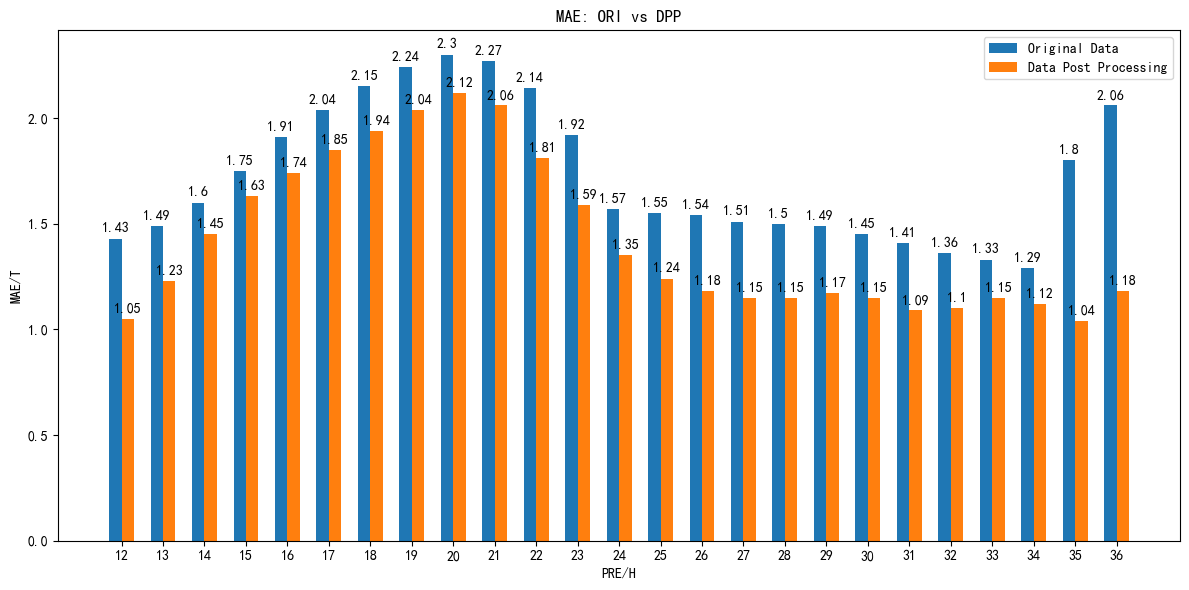

In [399]:
# 平均绝对偏差
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
labels = range(12,37)
Original =MAE_model
DataPostProcessing = MAE_NN

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6),dpi=100)
rects1 = ax.bar(x - width/2, Original, width, label='Original Data')
rects2 = ax.bar(x + width/2, DataPostProcessing, width, label='Data Post Processing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE/T')
ax.set_xlabel('PRE/H')
ax.set_title('MAE: ORI vs DPP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('/mnt1/zzzzzth/chongqing/test/figures/T_{}_MAE.png'.format(fcstime))
plt.show()

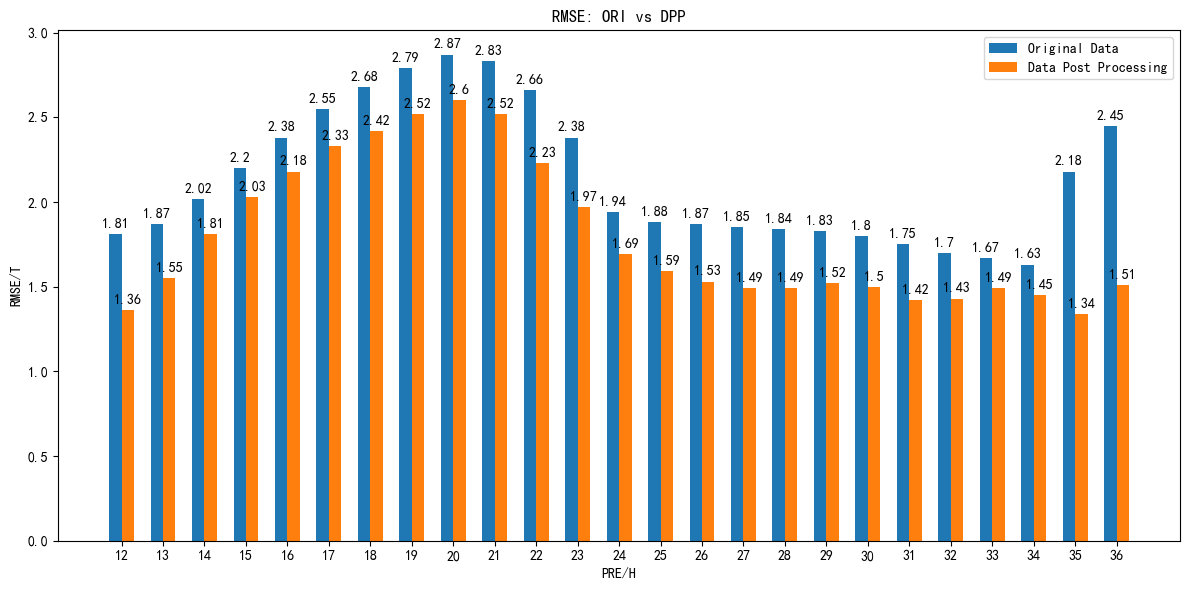

In [400]:
# 均方根误差
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
labels = range(12,37)
Original =RMSE_model
DataPostProcessing = RMSE_NN

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6),dpi=100)
rects1 = ax.bar(x - width/2, Original, width, label='Original Data')
rects2 = ax.bar(x + width/2, DataPostProcessing, width, label='Data Post Processing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE/T')
ax.set_xlabel('PRE/H')
ax.set_title('RMSE: ORI vs DPP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('/mnt1/zzzzzth/chongqing/test/figures/T_{}_RMSE.png'.format(fcstime))
plt.show()

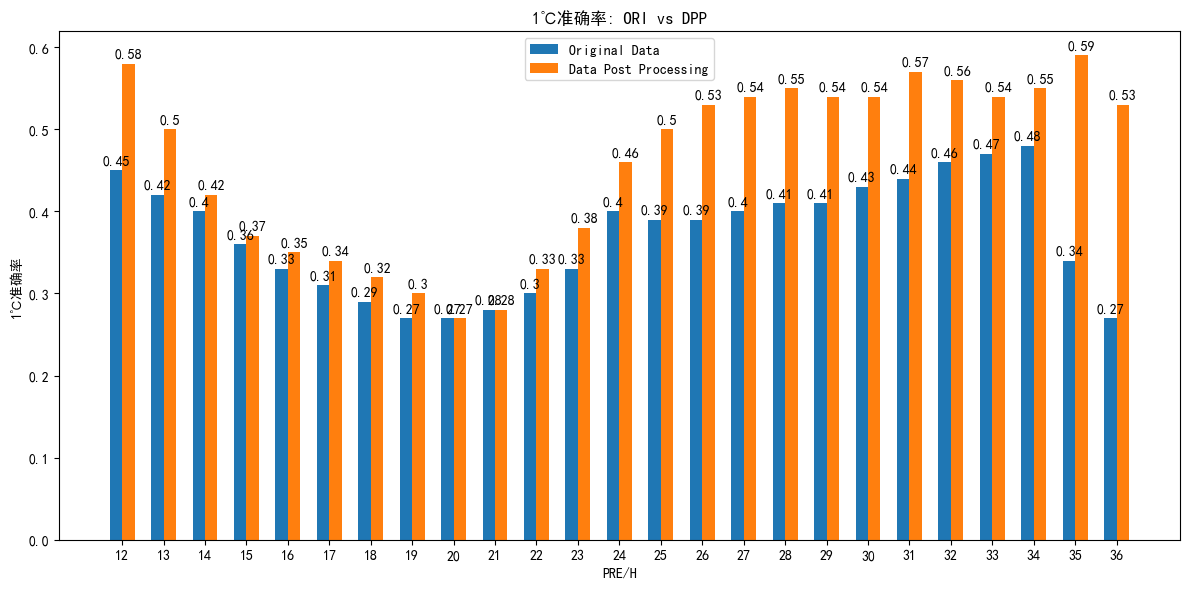

In [401]:
# 1度准确率
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
labels = range(12,37)
Original = ACC_1_model
DataPostProcessing = ACC_1_NN

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6),dpi=100)
rects1 = ax.bar(x - width/2, Original, width, label='Original Data')
rects2 = ax.bar(x + width/2, DataPostProcessing, width, label='Data Post Processing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('1℃准确率')
ax.set_xlabel('PRE/H')
ax.set_title('1℃准确率: ORI vs DPP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('/mnt1/zzzzzth/chongqing/test/figures/T_{}_ACC_1.png'.format(fcstime))
plt.show()

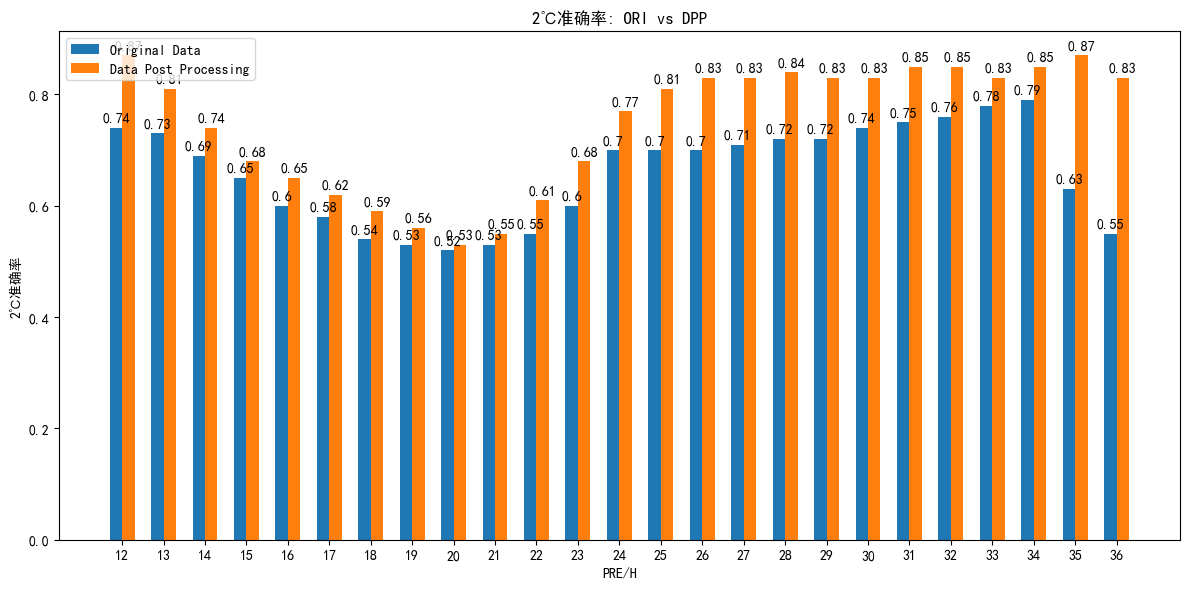

In [402]:
# 2度准确率
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
labels = range(12,37)
Original = ACC_2_model
DataPostProcessing = ACC_2_NN

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6),dpi=100)
rects1 = ax.bar(x - width/2, Original, width, label='Original Data')
rects2 = ax.bar(x + width/2, DataPostProcessing, width, label='Data Post Processing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('2℃准确率')
ax.set_xlabel('PRE/H')
ax.set_title('2℃准确率: ORI vs DPP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('/mnt1/zzzzzth/chongqing/test/figures/T_{}_ACC_2.png'.format(fcstime))
plt.show()